In [21]:
import requests, pandas as pd, numpy as np
from pandas import DataFrame
from io import StringIO
import time, json
from datetime import date
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import *
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [22]:
# df = pd.read_csv('./Datasets/bitcoin_price.csv', parse_dates=['Date'], usecols=['Date','Close'])
# df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv', parse_dates=['Timestamp'], usecols=['Timestamp','Close'])
df = pd.read_csv('bitstampUSD_1-min_data_2012-01-01_to_2018-01-08.csv')
df.isnull().values.any()

False

In [23]:
df.head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
2,1325318040,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
3,1325318100,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
4,1325318160,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
5,1325318220,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
6,1325318280,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
7,1325318340,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
8,1325318400,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
9,1325318460,4.39,4.39,4.39,4.39,0.455581,2.0,4.39


In [24]:
df['Date'] = pd.to_datetime(df['Timestamp'],unit='s').dt.date
group = df.groupby('Date')
Daily_Price = group['Weighted_Price'].mean()

Daily_Price.head()

Date
2011-12-31    4.472579
2012-01-01    4.680778
2012-01-02    5.000000
2012-01-03    5.145917
2012-01-04    5.195443
Name: Weighted_Price, dtype: float64

In [25]:
# convert the date column into a time series with daily frequency

df['Date'] = pd.to_datetime(df['Date'])

In [26]:
indexed_df = df.set_index('Date')

In [27]:
ts = indexed_df['Close']

In [28]:
ts.head()

Date
2011-12-31    4.39
2011-12-31    4.39
2011-12-31    4.39
2011-12-31    4.39
2011-12-31    4.39
Name: Close, dtype: float64

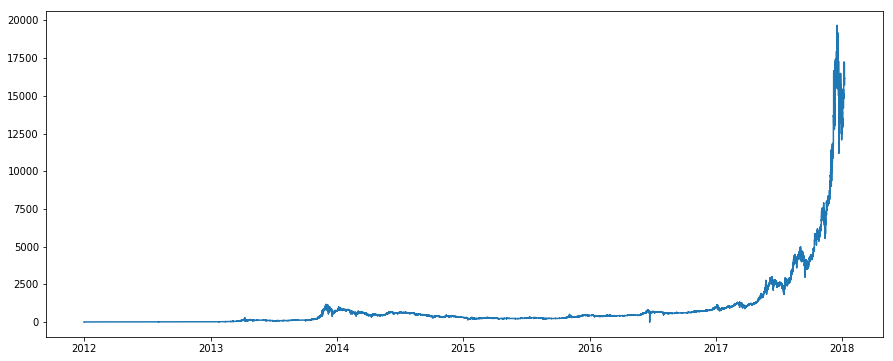

In [29]:
# visualize the time series to see how Bitcoin changes over time

plt.plot(ts)

In [30]:
# resamply by week

ts_week = ts.resample('W').mean()

In [31]:
ts_week

Date
2012-01-01        4.597101
2012-01-08        5.870809
2012-01-15        6.724608
2012-01-22        6.715125
2012-01-29        6.050626
2012-02-05        5.871852
2012-02-12        5.686942
2012-02-19        4.802238
2012-02-26        4.760391
2012-03-04        4.897774
2012-03-11        4.970852
2012-03-18        5.254234
2012-03-25        4.848571
2012-04-01        4.804050
2012-04-08        4.908586
2012-04-15        4.864256
2012-04-22        5.122293
2012-04-29        5.050317
2012-05-06        5.048331
2012-05-13        4.992232
2012-05-20        5.012282
2012-05-27        5.071747
2012-06-03        5.140668
2012-06-10        5.437460
2012-06-17        5.928801
2012-06-24        6.466184
2012-07-01        6.456854
2012-07-08        6.583296
2012-07-15        7.248218
2012-07-22        8.498597
                  ...     
2017-06-25     2649.635595
2017-07-02     2485.174654
2017-07-09     2554.736292
2017-07-16     2257.545421
2017-07-23     2486.670937
2017-07-30     2653.916

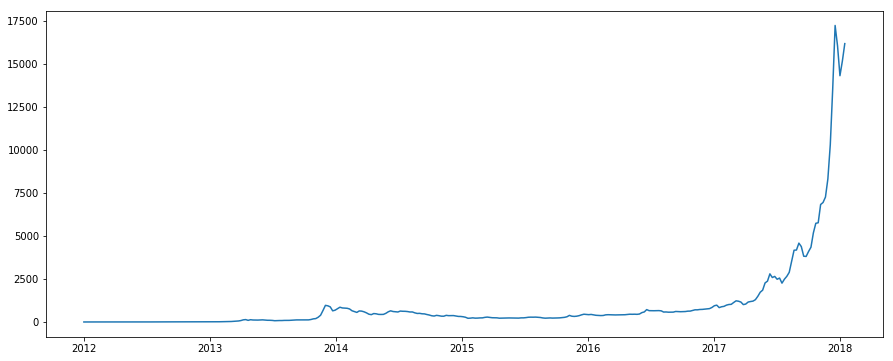

In [32]:
plt.plot(ts_week)

In [38]:
# check for stationarity

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='green',label='Bitcoin Data')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('Time(Days)',fontsize=24)
    plt.ylabel('$(Dollar)',fontsize=24)
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

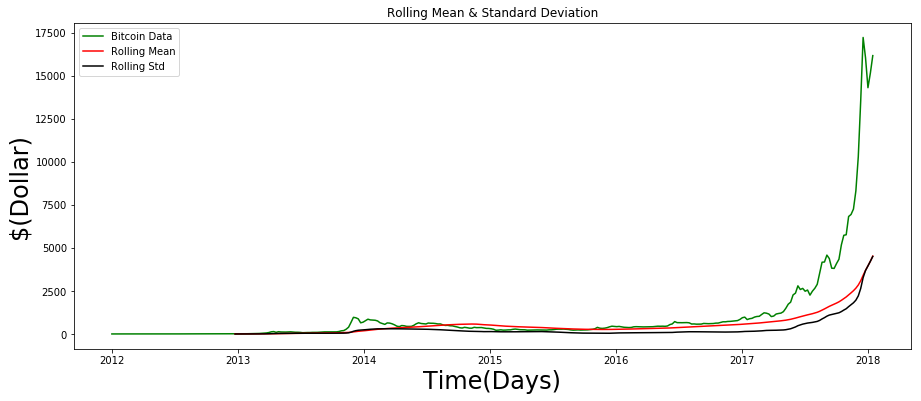

Results of Dickey-Fuller Test:
Test Statistic                   3.544263
p-value                          1.000000
#Lags Used                      15.000000
Number of Observations Used    300.000000
Critical Value (1%)             -3.452337
Critical Value (5%)             -2.871223
Critical Value (10%)            -2.571929
dtype: float64


In [39]:
test_stationarity(ts_week)

Because the test statistic is more than the 5% critical value and the p-value is larger than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected. This shows that the weekly time series is not stationary.
Before you can apply ARIMA models for forecasting, you need to transform this time series into a stationary time series.

In [40]:
# apply a non linear log transform

ts_week_log = np.log(ts_week)

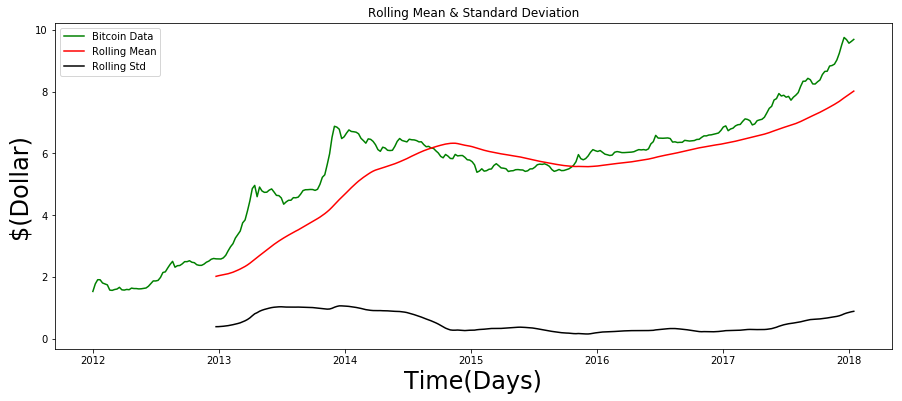

Results of Dickey-Fuller Test:
Test Statistic                  -0.202453
p-value                          0.938229
#Lags Used                       1.000000
Number of Observations Used    314.000000
Critical Value (1%)             -3.451349
Critical Value (5%)             -2.870789
Critical Value (10%)            -2.571698
dtype: float64


In [41]:
test_stationarity(ts_week_log)

The Dickey-Fuller test results confirm that the series is still non-stationary. Again the test statistic is larger than the 5% critical value and the p-value larger than 0.05.

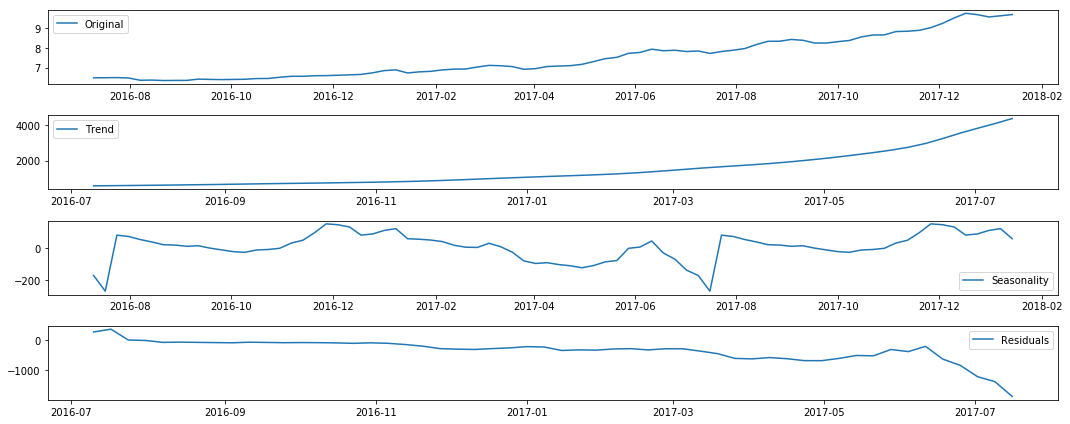

In [42]:
# remove trend and seasonality with decomposition

decomposition = seasonal_decompose(ts_week)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_week_log[-80:], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend[-80:], label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[-80:],label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual[-80:], label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Text(0.5,1,'Seasonality')

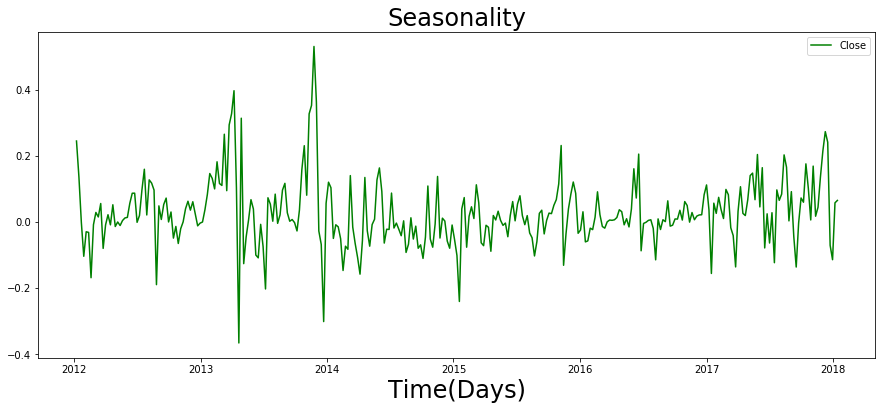

In [45]:
# remove trend and seasonality with differencing

ts_week_log_diff = ts_week_log - ts_week_log.shift()
plt.plot(ts_week_log_diff,color='green')
plt.legend(loc='best')
plt.xlabel('Time(Days)',fontsize=24)
# plt.ylabel('$(Dollar)',fontsize=24)
plt.title('Seasonality',fontsize=24)

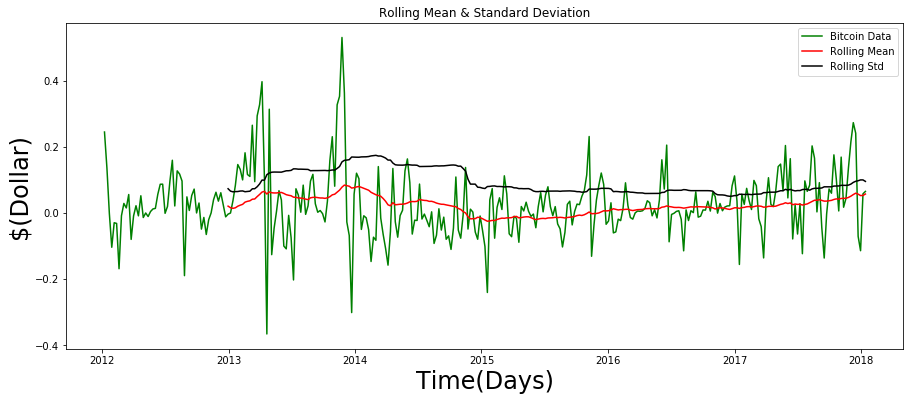

Results of Dickey-Fuller Test:
Test Statistic                -1.177937e+01
p-value                        1.043719e-21
#Lags Used                     0.000000e+00
Number of Observations Used    3.140000e+02
Critical Value (1%)           -3.451349e+00
Critical Value (5%)           -2.870789e+00
Critical Value (10%)          -2.571698e+00
dtype: float64


In [46]:
ts_week_log_diff.dropna(inplace=True)
test_stationarity(ts_week_log_diff)

In [47]:
size = int(len(ts_week_log)*(0.7))
train, test = ts_week_log[0:size], ts_week_log[size:len(ts_week_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


0.9940155964043974


Printing Mean Squared Error of Predictions...
Test MSE: 0.006440


In [48]:
predictions_series = pd.Series(predictions, index = test.index)

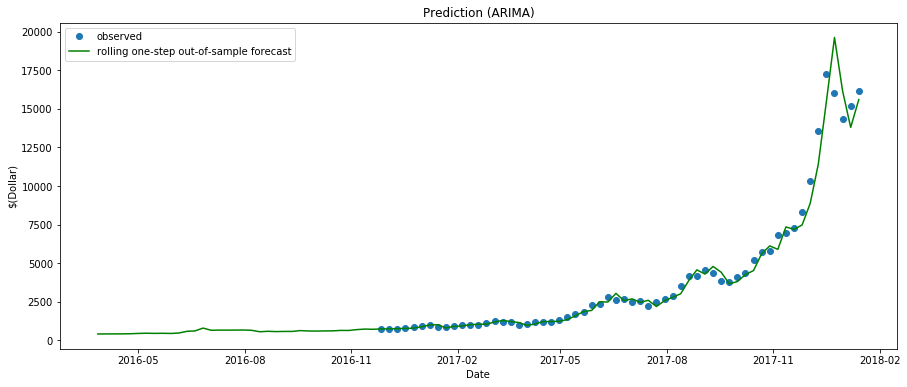

In [53]:
fig, ax = plt.subplots()
ax.set(title='Prediction (ARIMA)', xlabel='Date', ylabel='$(Dollar)')
ax.plot(ts_week[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [52]:
r2

0.9940155964043974